# Hyperparameter Tuning

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math604/blob/master/static_files/presentations/07_Hyperparameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math604/blob/master/static_files/presentations/07_Hyperparameter.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

## Setup

In [ ]:
%pip install optuna -q
%pip install keras-tuner -q
%pip install autokeras -q
%pip install wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00


In [ ]:
# Python ≥3.7 is recommended
import sys
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥1.01 is recommended
from packaging import version
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Tensorflow ≥2.8.0 is recommended
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import optuna 
from optuna.samplers import GridSampler, RandomSampler, TPESampler
import keras_tuner as kt
import autokeras as ak

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback, WandbCallback

# Common imports
import numpy as np
import pandas as pd
import os
from random import shuffle
import random
import time
import math
import pprint

# To plot pretty figures
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

## Hyparameter tuning for `sklearn`

Hyper-parameters are parameters that are not directly learnt within estimators. In `scikit-learn` they are passed as arguments to the constructor of the estimator classes. Typical examples include `C`, `kernel` and `gamma` for Support Vector Classifier, `alpha` for Lasso, etc.

It is possible and recommended to search the hyper-parameter space for the best cross validation score. Any parameter provided when constructing an estimator may be optimized in this manner. Specifically, to find the names and current values for all parameters for a given estimator, we can use `estimator.get_params()`.

A search consists of:
- an estimator (regressor or classifier such as `sklearn.svm.SVC()`);
- a parameter space;
- a method for searching or sampling candidates;
- a cross-validation scheme; and
- a score function.

> Note that it is common that a small subset of those parameters can have a large impact on the predictive or computation performance of the model while others can be left to their default values. **It is recommended to read the docstring of the estimator class to get a finer understanding of their expected behavior.**

Let us load the example dataset first:

In [ ]:
# load data
digits = datasets.load_digits()

# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.25, shuffle=False)

In [ ]:
X_train.shape

(1347, 64)

### Grid search

The grid search provided by `GridSearchCV()` exhaustively generates candidates from a grid of parameter values specified with the `param_grid` parameter. Here our estimator is [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [ ]:
# random forest classifier object
rfc = RandomForestClassifier(random_state=42)

# define sample space
param_grid = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 3, 4],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 6, 7]
    }

First, let’s obtain the optimal hyperparameters using the grid search method and time the process. This means that we will test all 108 hyperparameter sets and pick out the one that yields the best results.

In [ ]:
# create grid search object
gs = GridSearchCV(estimator=rfc,
                  param_grid=param_grid,
                  scoring='f1_micro',
                  cv=5,
                  verbose=2)

gs.fit(X_train, y_train)

Here, we will use `Optuna` instead:

In [ ]:
def objective(trial):
    """return the f1-score"""

    # search space
    n_estimators =  trial.suggest_int('n_estimators', low=100, high=200, step=50)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    min_samples_split = trial.suggest_int('min_samples_split', low=2, high=4, step=1)
    max_depth = trial.suggest_int('max_depth', low=5, high=7, step=1)
    max_features = trial.suggest_categorical('max_features', ['sqrt','log2'])
    # random forest classifier object
    rfc = RandomForestClassifier(n_estimators=n_estimators, 
                                                  criterion=criterion,
                                                  min_samples_split=min_samples_split,
                                                  max_depth=max_depth,
                                                  max_features=max_features,
                                                  random_state=42)
    score =  cross_val_score(estimator=rfc, 
                             X=X_train, 
                             y=y_train, 
                             scoring='f1_micro',
                             cv=5).mean()
    return score

In [ ]:
# create a study (aim to maximize score)
search_space = param_grid
study = optuna.create_study(sampler=GridSampler(param_grid), direction='maximize')

# perform hyperparamter tuning (while timing the process)
time_start = time.time()
study.optimize(objective, show_progress_bar=True, n_trials=108)
time_grid = time.time() - time_start

# store result in a data frame 
columns = ['Number of iterations', 'Iteration Number of Optimal Hyperparamters', 'Score', 'Time Elapsed (s)']
values_grid = [108, study.best_trial.number, study.best_trial.value, time_grid]
results_grid = pd.DataFrame([values_grid], columns = columns)

[I 2023-05-24 03:32:56,934] A new study created in memory with name: no-name-185675b5-a671-4372-8e9a-468be41c2e10
/usr/local/lib/python3.10/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/108 [00:00<?, ?it/s]

[I 2023-05-24 03:32:59,443] Trial 0 finished with value: 0.912405342145119 and parameters: {'n_estimators': 200, 'criterion': 'gini', 'min_samples_split': 4, 'max_depth': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.912405342145119.
[I 2023-05-24 03:33:02,630] Trial 1 finished with value: 0.9250227178851714 and parameters: {'n_estimators': 200, 'criterion': 'gini', 'min_samples_split': 2, 'max_depth': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.9250227178851714.
[I 2023-05-24 03:33:05,533] Trial 2 finished with value: 0.9324631694891918 and parameters: {'n_estimators': 200, 'criterion': 'entropy', 'min_samples_split': 3, 'max_depth': 7, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9324631694891918.
[I 2023-05-24 03:33:06,777] Trial 3 finished with value: 0.9183367754371471 and parameters: {'n_estimators': 100, 'criterion': 'entropy', 'min_samples_split': 3, 'max_depth': 6, 'max_features': 'log2'}. Best is trial 2 with value: 0.9324631694891918.
[I 2

In [ ]:
study.best_params

{'n_estimators': 150,
 'criterion': 'entropy',
 'min_samples_split': 3,
 'max_depth': 7,
 'max_features': 'sqrt'}

### Random Search

While using a grid of parameter settings is currently the most widely used method for parameter optimization, other search methods have more favorable properties. `RandomizedSearchCV` implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:

- A budget can be chosen independent of the number of parameters and possible values.
- Adding parameters that do not influence the performance does not decrease efficiency.

Specifying how parameters should be sampled is done using a dictionary, very similar to specifying parameters for `GridSearchCV`. Additionally, a computation budget, being the number of sampled candidates or sampling iterations, is specified using the `n_iter` parameter. For each parameter, either a distribution over possible values or a list of discrete choices (which will be sampled uniformly) can be specified.

In [ ]:
# create a random search object
rs = RandomizedSearchCV(estimator=rfc,
                  param_distributions=param_grid,
                  scoring='f1_micro',
                  cv=5,
                  n_jobs=-1,
                  verbose=2,
                  n_iter=50)

rs.fit(X_train, y_train)

Here, we will use `Optuna` instead:

In [ ]:
# create a study (aim to maximize score)
study = optuna.create_study(sampler=RandomSampler(), direction='maximize')

# perform hyperparamter tuning (while timing the process)
time_start = time.time()
study.optimize(objective, show_progress_bar=True, n_trials=50)
time_random = time.time() - time_start

# store result in a data frame 
columns = ['Number of iterations', 'Iteration Number of Optimal Hyperparamters', 'Score', 'Time Elapsed (s)']
values_random = [50, study.best_trial.number, study.best_trial.value, time_random]
results_random = pd.DataFrame([values_random], columns = columns)

[I 2023-05-24 03:36:53,501] A new study created in memory with name: no-name-6b952135-06c4-4c62-bfe4-10f435063be0
/usr/local/lib/python3.10/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-05-24 03:36:56,505] Trial 0 finished with value: 0.9116618477213272 and parameters: {'n_estimators': 200, 'criterion': 'entropy', 'min_samples_split': 2, 'max_depth': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9116618477213272.
[I 2023-05-24 03:36:58,816] Trial 1 finished with value: 0.9064628941208868 and parameters: {'n_estimators': 200, 'criterion': 'entropy', 'min_samples_split': 2, 'max_depth': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.9116618477213272.
[I 2023-05-24 03:37:00,477] Trial 2 finished with value: 0.9146413327825968 and parameters: {'n_estimators': 100, 'criterion': 'gini', 'min_samples_split': 4, 'max_depth': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9146413327825968.
[I 2023-05-24 03:37:02,120] Trial 3 finished with value: 0.8938372573316811 and parameters: {'n_estimators': 100, 'criterion': 'gini', 'min_samples_split': 3, 'max_depth': 5, 'max_features': 'log2'}. Best is trial 2 with value: 0.9146413327825968.
[I

In [ ]:
study.best_params

{'n_estimators': 100,
 'criterion': 'entropy',
 'min_samples_split': 2,
 'max_depth': 7,
 'max_features': 'log2'}

### Bayesian Optimization

Finally, we perform hyperparameter tuning with the Bayesian optimization and time the process. In Python, this can be accomplished with the `Optuna` module.

In [ ]:
# create a study (aim to maximize score)
study = optuna.create_study(sampler=TPESampler(), direction='maximize')

# perform hyperparamter tuning (while timing the process)
time_start = time.time()
study.optimize(objective, show_progress_bar=True, n_trials=50)
time_bayesian = time.time() - time_start

# store result in a data frame 
values_bayesian = [50, study.best_trial.number, study.best_trial.value, time_bayesian]
results_bayesian = pd.DataFrame([values_bayesian], columns = columns)

[I 2023-05-24 03:39:05,603] A new study created in memory with name: no-name-fc37470e-3f6d-4b2a-ba76-90827f032e79
/usr/local/lib/python3.10/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-05-24 03:39:10,555] Trial 0 finished with value: 0.90868787002616 and parameters: {'n_estimators': 100, 'criterion': 'gini', 'min_samples_split': 2, 'max_depth': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.90868787002616.
[I 2023-05-24 03:39:13,367] Trial 1 finished with value: 0.9220570012391572 and parameters: {'n_estimators': 150, 'criterion': 'gini', 'min_samples_split': 2, 'max_depth': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.9220570012391572.
[I 2023-05-24 03:39:14,553] Trial 2 finished with value: 0.9205782734407271 and parameters: {'n_estimators': 100, 'criterion': 'gini', 'min_samples_split': 2, 'max_depth': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9220570012391572.
[I 2023-05-24 03:39:16,294] Trial 3 finished with value: 0.9257662123089634 and parameters: {'n_estimators': 150, 'criterion': 'gini', 'min_samples_split': 3, 'max_depth': 7, 'max_features': 'log2'}. Best is trial 3 with value: 0.9257662123089634.
[I 2023-05-2

In [ ]:
study.best_params

{'n_estimators': 100,
 'criterion': 'entropy',
 'min_samples_split': 2,
 'max_depth': 7,
 'max_features': 'sqrt'}

We summarized the results below:

In [ ]:
# store all results in a single data frame
df = results_grid.append(results_random).append(results_bayesian)
df.index = ['Grid Search', 'Random Search', 'Bayesian Optimization']
df

<ipython-input-74-d05524eba8c7>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = results_grid.append(results_random).append(results_bayesian)


,Number of iterations,Iteration Number of Optimal Hyperparamters,Score,Time Elapsed (s)
Grid Search,108,106,0.935426,236.524639
Random Search,50,12,0.930960,99.094361
Bayesian Optimization,50,47,0.934685,104.101121


The grid search registered the highest score. However, the method required more trials and only managed to obtain the optimal hyperparameters at the 106th iteration. Also, its run time far exceeded that of the random search and the Bayesian optimization methods. The random search method required only 50 trials and needed only 12 iterations to find the best hyperparameter set. It also took the least amount of time to execute. However, the random search method registered the lowest score out of the 3 methods. The Bayesian optimization also performed 50 trials but was able to achieve the highest score after only 47 iterations, far less than the grid search. Although it executed the same number of trials as the random search, it has a longer run time since it is an informed search method.

## Hyperparamter tuning using `KerasTuner`

Training the weights of a model is relatively easy: you compute a loss function on a mini-batch of data and then use backpropagation to move the weights in the right direction. Updating hyperparameters, on the other hand, presents unique challenges. Consider these points:

- The hyperparameter space is typically made up of discrete decisions and thus
isn't continuous or differentiable. Hence, you typically can't do gradient descent in hyperparameter space. Instead, you must rely on gradient-free optimization techniques, which naturally are far less efficient than gradient descent.
- Computing the feedback signal of this optimization process (does this set of
hyperparameters lead to a high-performing model on this task?) can be extremely
expensive: it requires creating and training a new model from scratch on your
dataset.
- The feedback signal may be noisy: if a training run performs 0.2% better, is that because of a better model configuration, or because you got lucky with the initial weight values?

Thankfully, there's a tool that makes hyperparameter tuning simpler: `KerasTuner`. Let's check it out.

`KerasTuner` lets you replace hard-coded hyperparameter values, such as `units=32`, with a range of possible choices, such as `Int(name="units", min_value=16, max_value=64, step=16)`. This set of choices in a given model is called the search space of the hyperparameter tuning process.

To specify a search space, define a model-building function. It takes an hp argument, from which you can sample hyperparameter ranges, and it returns a compiled Keras model.

### Tune model architecture

In [ ]:
def build_model(hp):
    # Sample hyperparameter values from the hp object. After sampling, these values (such as the "units" which is number of nuerons 
    # variable here) are just regular Python constants.
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(        
            tf.keras.layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=16, max_value=64, step=16),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(tf.keras.layers.Dropout(rate=0.25))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
    return model

If you want to adopt a more modular and configurable approach to model-building,
you can also subclass the `HyperModel` class and define a `build()` method, as follows.

In [ ]:
class SimpleMLP(kt.HyperModel):
    # Thanks to the object-oriented approach, we can configure model constants
    # as constructor arguments (instead of hardcoding them in the model-building
    # function).
    def __init__(self, num_classes):
        self.num_classes = num_classes
    # The build() method is identical to our prior build_model() standalone function.
    def build(self, hp):
      # Sample hyperparameter values from the hp object. After sampling, these values (such as the "units" which is number of nuerons 
      # variable here) are just regular Python constants.
        model = tf.keras.keras.Sequential()
        model.add(tf.keras.layers.Flatten())
        # Tune the number of layers.
        for i in range(hp.Int("num_layers", 1, 3)):
            model.add(        
              tf.keras.layers.Dense(
              # Tune number of units.
              units=hp.Int("units", min_value=16, max_value=64, step=16),
              # Tune the activation function to use.
              activation=hp.Choice("activation", ["relu", "tanh"]),
              )
            )
        # Tune whether to use dropout.
        if hp.Boolean("dropout"):
            model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(self.num_classes, activation="softmax"))
        # Define the optimizer learning rate as a hyperparameter.
        learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
        model.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
        return model

hypermodel = SimpleMLP(num_classes=10)

The next step is to define a “tuner.” Schematically, you can think of a tuner as a for loop that will repeatedly
 
1. Pick a set of hyperparameter values
2. Call the model-building function with these values to create a model
3. Train the model and record its metrics

KerasTuner has several built-in tuners available— **RandomSearch, BayesianOptimization, and Hyperband**. Let’s try BayesianOptimization, a tuner that attempts to make smart predictions for which new hyperparameter values are likely to perform best given the outcomes of previous choices:

In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=3, # Increase this if you would like to do more search
    executions_per_trial=2,
    directory="mnist_kt_test",
    overwrite=True,
)

- `objective`: Specify the metric that the tuner will seek to optimize. Always specify validation metrics, since the goal of the search process is to find models that generalize!

- `max_trials`: Maximum number of different model configurations (“trials”) to try before ending the search.

- `executions_per_trial`: To reduce metrics variance, you can train the same model multiple times and average the results. `executions_per_trial` is how many training rounds(executions) to run for each model configuration (trial).

- `directory`: Where to store search logs

- `overwrite`: Whether to overwrite data in directory to start a new search. Set this to `True` if you’ve modified the model-building function, or to `False` to resume a previously started search with the same model-building function.

You can display an overview of the search space via `search_space_summary()`:

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
optimizer (Choice)
{'default': 'rmsprop', 'conditions': [], 'values': ['rmsprop', 'adam'], 'ordered': False}


Finally, let’s launch the search. **Don’t forget to pass validation data, and make sure not to use your test set as validation data** — otherwise you’d quickly start overfitting to your test data, and you wouldn’t be able to trust your test metrics anymore:

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((-1, 28 * 28)).astype("float32") / 255
x_test = x_test.reshape((-1, 28 * 28)).astype("float32") / 255
# Reserve these for later.
x_train_full = x_train[:]
y_train_full = y_train[:]
num_val_samples = 10000
# Set these aside as a validation set.
x_train, x_val = x_train[:-num_val_samples], x_train[-num_val_samples:]
y_train, y_val = y_train[:-num_val_samples], y_train[-num_val_samples:]

# This takes the same arguments as fit() (it simply passes them
# down to fit() for each new model).
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]
# Use a large number of epochs (you don’t know in advance how
# many epochs each model will need), and use an EarlyStopping
# callback to stop training when you start overfitting.
tuner.search(
    x_train, y_train,
    batch_size=128,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=2,
)

Trial 3 Complete [00h 03m 17s]
val_accuracy: 0.9639500081539154

Best val_accuracy So Far: 0.9647500216960907
Total elapsed time: 00h 07m 45s


The preceding example will run in just a few minutes, since we’re only looking at a few possible choices and we’re training on MNIST. However, with a typical search space and dataset, you’ll often find yourself letting the hyperparameter search run overnight or even over several days. **If your search process crashes, you can always restart it — just specify `overwrite=False` in the tuner so that it can resume from the trial logs stored on disk.**

Once the search is complete, you can query the best hyperparameter configurations, which you can use to create high-performing models that you can then retrain.

#### Querying the best hyperparameter configurations

In [ ]:
top_n = 3
best_hps = tuner.get_best_hyperparameters(top_n)

Usually, when retraining these models, **you may want to include the validation data as part of the training data, since you won’t be making any further hyperparameter changes, and thus you will no longer be evaluating performance on the validation data.** In our example, we’d train these final models on the totality of the original MNIST training data, without reserving a validation set.

Before we can train on the full training data, though, there’s one last parameter we need to settle: the optimal number of epochs to train for. Typically, you’ll want to train the new models for longer than you did during the search: using an aggressive patience value in the `EarlyStopping` callback saves time during the search, but it may lead to under-fit models. Just use the validation set to find the best epoch:

In [ ]:
def get_best_epoch(hp):
    model = build_model(hp)
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=10)
    ]
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=100,
        batch_size=128,
        callbacks=callbacks)
    val_loss_per_epoch = history.history["val_loss"]
    best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
    print(f"Best epoch: {best_epoch}")
    return best_epoch, model

Finally, train on the full dataset for just a bit longer than this epoch count, since you’re training on more data; 20% more in this case:

In [ ]:
def get_best_trained_model(hp):
    best_epoch, model = get_best_epoch(hp)
    model.fit(
        x_train_full, y_train_full,
        batch_size=128, epochs=int(best_epoch * 1.2))
    return model

best_models = []
for hp in best_hps:
    model = get_best_trained_model(hp)
    model.evaluate(x_test, y_test)
    best_models.append(model)

Epoch 1/100
391/391 [==============================] - 2s 4ms/step - loss: 0.6390 - accuracy: 0.8321 - val_loss: 0.3086 - val_accuracy: 0.9149
Epoch 2/100
391/391 [==============================] - 1s 4ms/step - loss: 0.3483 - accuracy: 0.9005 - val_loss: 0.2482 - val_accuracy: 0.9301
Epoch 3/100
391/391 [==============================] - 1s 3ms/step - loss: 0.3063 - accuracy: 0.9109 - val_loss: 0.2270 - val_accuracy: 0.9338
Epoch 4/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2823 - accuracy: 0.9172 - val_loss: 0.2175 - val_accuracy: 0.9370
Epoch 5/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2644 - accuracy: 0.9217 - val_loss: 0.1991 - val_accuracy: 0.9419
Epoch 6/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2518 - accuracy: 0.9260 - val_loss: 0.1919 - val_accuracy: 0.9449
Epoch 7/100
391/391 [==============================] - 1s 3ms/step - loss: 0.2422 - accuracy: 0.9277 - val_loss: 0.1835 - val_accuracy: 0.9472

Note that if you’re not worried about slightly underperforming, there’s a shortcut you can take: just use the tuner to reload the top-performing models with the best weights saved during the hyperparameter search, without retraining new models from scratch:

In [ ]:
models = tuner.get_best_models(top_n)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 28, 28))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [ ]:
best_model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.1319 - accuracy: 0.9616


[0.1318952739238739, 0.9616000056266785]

You can also print a summary of the search results.

In [ ]:
tuner.results_summary()

Results summary
Results in mnist_kt_test/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
num_layers: 1
units: 32
activation: tanh
dropout: True
lr: 0.001023588238883239
optimizer: adam
Score: 0.9647500216960907

Trial 2 summary
Hyperparameters:
num_layers: 1
units: 32
activation: tanh
dropout: True
lr: 0.00020952911266579243
optimizer: rmsprop
Score: 0.9639500081539154

Trial 1 summary
Hyperparameters:
num_layers: 1
units: 16
activation: relu
dropout: True
lr: 0.004306213731281972
optimizer: rmsprop
Score: 0.9480000138282776


### Tune model training

To tune the model building process, we need to subclass the `HyperModel` class, which also makes it easy to share and reuse hypermodels.

We need to override `HyperModel.build()` and `HyperModel.fit()` to tune the model building and training process respectively. A `HyperModel.build()` method is the same as the model-building function, which creates a Keras model using the hyperparameters and returns it.

In [ ]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Flatten())
        model.add(
            tf.keras.layers.Dense(
                units=hp.Int("units", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
        model.add(tf.keras.layers.Dense(10, activation="softmax"))
        model.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            # Tune whether to shuffle the data in each epoch!
            shuffle=hp.Boolean("shuffle"),
            **kwargs,
        )

We can do a quick check to see if the code works correctly by using a small amount of random data.

In [ ]:
hp = kt.HyperParameters()
hypermodel = MyHyperModel()
model = hypermodel.build(hp)
hypermodel.fit(hp, model, np.random.rand(100, 28, 28), np.random.rand(100, 10))

4/4 [==============================] - 1s 7ms/step - loss: 12.5933 - accuracy: 0.1000


### Tune data preprocessing

To tune data preprocessing, we just add an additional step in `HyperModel.fit()`, where we can access the dataset from the arguments. In the following code, we tune whether to normalize the data before training the model. This time we explicitly put x and y in the function signature because we need to use them.

In [ ]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Flatten())
        model.add(
            tf.keras.layers.Dense(
                units=hp.Int("units", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
        model.add(tf.keras.layers.Dense(10, activation="softmax"))
        model.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],
        )
        return model

    def fit(self, hp, model, x, y, **kwargs):
        # Tune whether to add normalize layer!
        if hp.Boolean("normalize"):
            x = tf.keras.layers.Normalization()(x)
        return model.fit(
            x,
            y,
            shuffle=hp.Boolean("shuffle"),
            **kwargs,
        )


hp = kt.HyperParameters()
hypermodel = MyHyperModel()
model = hypermodel.build(hp)
hypermodel.fit(hp, model, np.random.rand(100, 28, 28), np.random.rand(100, 10))

4/4 [==============================] - 1s 5ms/step - loss: 12.3237 - accuracy: 0.0900


For more information, please refer to https://keras.io/keras_tuner/

## Network architecture search with `AutoKeras`

Let's now build up an AutoML pipeline to improve the CNN structure and achieve better classification accuracy.

Creating an AutoML pipeline with the `AutoKeras` functional API is quite similar to building up a neural network with the `Keras` functional API. The only difference is that the `Keras` layers are replaced with `AutoKeras`'s built-in AutoML blocks. Each block contains one or more deep learning models (or preprocessing methods) and a default search space for their hyperparameters. You can also modify the search space for each hyperparameter. To build up a network, we stack multiple Keras layers by wiring together their inputs and outputs sequentially. Specifically, it often contyains the following blocks:

- **Input node**: which is a placeholder for the tensor input of the pipeline, such as `ImageInput`, `TextInput`, or `StructuredDataInput`. You can also define a general tensor input with the Input class in `AutoKeras`. The input node accepts data in multiple formats, such as `Numpy` arrays, `Pandas` DataFrames, and `TensorFlow` Datasets. It will also conduct certain preprocessing operations automatically, such as extending the dimensions of images if they do not have a channel dimension. The input node does not have any hyperparameters that can be set or tuned.
- **Preprocessor**: which is block defines additional preprocessing operations to perform on the inputs, such as image normalization, text embedding, and so on. Depending on the operation, there may be hyperparameters to tune, such as the maximum size of the vocabulary table to use to convert text documents to their vector representations if text embedding is performed. In this block, there are no weights to be trained through backpropagation.
- **Network**: which is the most important type of AutoML block in `AutoKeras`. Each block represents a set of neural network models of the same structure. For example, a `ConvBlock`. The number and types of layers are treated as hyperparameters. You can select one or more network blocks to create the pipelines based on the task at hand, and specify the search space of their hyperparameters based on your requirements. Unlike the preprocessor block, there are weights to be trained through backpropagation after specifying the hyperparameters in the network block.
- **Head**: which is a task-specific component used to generate the final outputs, such as the `ClassificationHead` and `RegressionHead`. It reshapes each instance's representation to a vector and applies a dense layer to transform it to the size of the target output. For example, if the head is a `ClassificationHead` and the problem is a binary classification problem, the output of each instance from the dense layer will be a vector of length two corresponding to the two labels. Each head also specifies the loss function and metrics to help compile each deep learning pipeline selected from the search space for training.

### Tuning CNNs for image classification

We leverage a `ConvBlock` in `AutoKeras` to tune the three main hyperparameters of the CNN: **the number of filters, the number of convolutional layers, and the kernel size** of the convolutional layers. A `ConvBlock` sequentially stacks multiple convolutional blocks (or convolutional cells). Each convolutional block sequentially stacks multiple convolutional layers, a max pooling layer, and a dropout layer.

All the convolutional blocks have the same number of convolutional layers, but there can be a different number of filters in each layer. There are seven hyperparameters in the search space of a `ConvBlock`:

- Number of convolutional blocks.
- Number of convolutional layers in each block. This is the same in all the convolutional blocks.
- Type of the convolutional layer. Each convolutional layer can be one of two types: it can be a regular 2D convolutional layer or a separable convolutional layer, which contains fewer weights than a normal convolutional layer but may achieve comparable performance.
- Number of filters in the convolutional layer. This can be different for each layer of each block.
- Kernel size of the convolutional layer. The kernel size of the max pooling layers is set to be the kernel size minus one. Once the kernel size is selected by the tuning algorithm for a ConvBlock in a trial, it will be applied for every pooling layer and convolutional layer in all the cells of that ConvBlock.
- Whether to apply the max pooling layer in each cell. Once this is selected for a trial, it’s applied for every cell in the ConvBlock.
- Whether to apply the dropout layer in each cell. Once this is selected for a trial, it’s applied for every cell in the ConvBlock.

To keep this example simple, we’ll constrain the search space by fixing the number of blocks as two. We do not apply the dropout layer or use separable convolutional layers. **The hyperparameters to be tuned are the number of layers, the kernel size, and the number of filters in each layer in the blocks. By default, they are selected from the lists `[1, 2]`, `[3, 5, 7]`, and `[16, 32, 64, 128, 256, 512]`, respectively.**

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# The model
input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node = ak.ConvBlock(
    # do not specify if we want to let it to search automatically
    num_blocks=2, max_pooling=True, separable=False, dropout=0.0
)(output_node)
output_node = ak.ClassificationHead(dropout=0.0)(output_node)
auto_model = ak.AutoModel(
    inputs=input_node, outputs=output_node, max_trials=10, overwrite=True, seed=42
)

# You may run with the full dataset, but expect a longer training time.
auto_model.fit(x_train, y_train, epochs=3)

Trial 10 Complete [00h 00m 54s]
val_loss: 0.03022073395550251

Best val_loss So Far: 0.03022073395550251
Total elapsed time: 00h 07m 25s
Epoch 1/3
1875/1875 [==============================] - 20s 9ms/step - loss: 0.1914 - accuracy: 0.9415
Epoch 2/3
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0371 - accuracy: 0.9890
Epoch 3/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0143 - accuracy: 0.9958


In [ ]:
test_loss, test_acc = auto_model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: ", test_acc)

Test accuracy:  0.9929999709129333


The best CNN achieves 99.3% accuracy on the test set. To discover smaller architectures, we can limit the number of layers and filters in the search space. It is possible to find a smaller architecture with comparableb performance to the CNN we constructed here.

In [ ]:
best_model = auto_model.export_model()
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 28, 28)           0         
 t32)                                                            
                                                                 
 expand_last_dim (ExpandLast  (None, 28, 28, 1)        0         
 Dim)                                                            
                                                                 
 normalization (Normalizatio  (None, 28, 28, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 256)       6656      
                                                             

### Automated pipeline search with `AutoKeras`

It is also possible to use `autoKeras` in AutoML applications: selecting the best types of components (models or preprocessors) to use in the deep learning pipeline. This is a more complex scenario than only tuning the hyperparameters of a specific type of model, as introduced in the previous section, because different models and preprocessors may compose different operations and have unique hyperparameters. It requires us to jointly select the combination of preprocessors and models and their coupled hyperparameters. 

For example, in image classification, there are a lot of advanced models proposed beyond the naive CNN we used previously, such as ResNet, Xception, and so on. You’ll also need to decide on suitable preprocessing methods, such as choosing whether to use normalization or not. We’ll work through some image classification examples here to show you how to automatically select models and preprocessing methods.

#### Automated selection of image preprocessing methods

In fact, it is also straightforward to extend the AutoML pipeline to tune and select a suitable data augmentation method — that is, to use an AutoML block to select and evaluate various data augmentation methods. The `ImageBlock` also allows us to select among multiple data preprocessing methods, such as deciding whether to use normalization and/or data augmentation methods to prepare the data.

Let’s use an image classification example to illustrate how to automatically select preprocessing methods for a ResNet model. We decide whether to use data augmentation and normalization methods or not. The dataset we use here is a subset of the CIFAR-10 dataset. To make things easier, we’ll only use images from two classes, "airplane" and "automobile." 

In [ ]:
#ssl._create_default_https_context = ssl._create_unverified_context
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("Training image shape:", x_train.shape)  # (60000, 28, 28)
print("Training label shape:", y_train.shape)  # (60000,)
print("First five training labels:", y_train[:5])  # array([5 0 4 1 9], dtype=uint8)

170498071/170498071 [==============================] - 2s 0us/step
Training image shape: (50000, 32, 32, 3)
Training label shape: (50000, 1)
First five training labels: [[6]
 [9]
 [9]
 [4]
 [1]]


In [ ]:
airplane_automobile_indices_train = (y_train[:, 0] == 0) | (y_train[:, 0] == 1)
airplane_automobile_indices_test = (y_test[:, 0] == 0) | (y_test[:, 0] == 1)
x_train, y_train = (
    x_train[airplane_automobile_indices_train],
    y_train[airplane_automobile_indices_train],
)
x_test, y_test = (
    x_test[airplane_automobile_indices_test],
    y_test[airplane_automobile_indices_test],
)
print("Training image shape:", x_train.shape)  # (60000, 28, 28)
print("Training label shape:", y_train.shape)  # (60000,)
print("First five training labels:", y_train[:5])  # array([5 0 4 1 9], dtype=uint8)

Training image shape: (10000, 32, 32, 3)
Training label shape: (10000, 1)
First five training labels: [[1]
 [1]
 [0]
 [0]
 [1]]


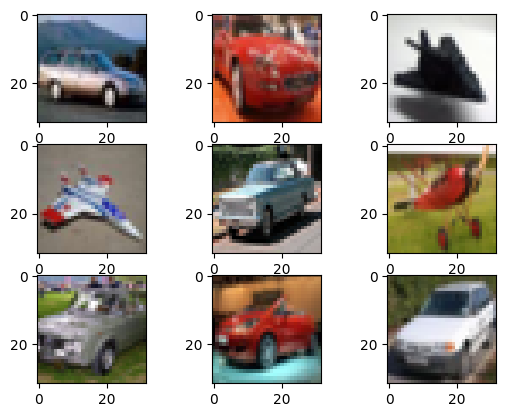

In [ ]:
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(x_train[i])

Let’s first create an AutoML pipeline to select the data augmentation method for the ResNet models. The pipeline has the same structure as the sequential AutoML pipelines we built in the previous section for tuning a single ResNet model. The only difference is that we add the image hyperblock (`ImageBlock`) in `AutoKeras` also contains preprocessing methods. The augmentation methods are selected along with the structure and other hyperparameters, such as the optimization method and learning rate.

In [ ]:
input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    # do not specify if we want to use normalization and let it to search automatically
    normalize=None,
    # do not specify if we want to use adata ugmentation method and let it to search automatically
    augment=None,
    # Only search resnet architectures.
    block_type="resnet",
)(input_node)
output_node = ak.ClassificationHead(dropout=0.0)(output_node)

auto_model = ak.AutoModel(
    inputs=input_node, outputs=output_node, max_trials=10, overwrite=True, seed=42
)

auto_model.fit(x_train, y_train, epochs=10, batch_size=64)

Trial 10 Complete [00h 02m 05s]
val_loss: 0.2805823087692261

Best val_loss So Far: 0.19601556658744812
Total elapsed time: 00h 19m 12s
Epoch 1/10
157/157 [==============================] - 39s 52ms/step - loss: 0.4771 - accuracy: 0.7922
Epoch 2/10
157/157 [==============================] - 7s 42ms/step - loss: 0.3570 - accuracy: 0.8460
Epoch 3/10
157/157 [==============================] - 7s 46ms/step - loss: 0.3102 - accuracy: 0.8693
Epoch 4/10
157/157 [==============================] - 7s 43ms/step - loss: 0.2904 - accuracy: 0.8785
Epoch 5/10
157/157 [==============================] - 7s 46ms/step - loss: 0.2678 - accuracy: 0.8889
Epoch 6/10
157/157 [==============================] - 7s 47ms/step - loss: 0.2402 - accuracy: 0.9012
Epoch 7/10
157/157 [==============================] - 7s 45ms/step - loss: 0.2284 - accuracy: 0.9058
Epoch 8/10
157/157 [==============================] - 7s 44ms/step - loss: 0.2169 - accuracy: 0.9135
Epoch 9/10
157/157 [==============================] - 7

In [ ]:
auto_model.tuner.results_summary()

Results summary
Results in ./auto_model
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 07 summary
Hyperparameters:
image_block_1/normalize: False
image_block_1/augment: True
image_block_1/res_net_block_1/pretrained: False
image_block_1/res_net_block_1/version: resnet50_v2
image_block_1/res_net_block_1/imagenet_size: False
classification_head_1/spatial_reduction_1/reduction_type: global_max
optimizer: adam
learning_rate: 0.001
image_block_1/image_augmentation_1/translation_factor: 0.1
image_block_1/image_augmentation_1/horizontal_flip: True
image_block_1/image_augmentation_1/vertical_flip: False
image_block_1/image_augmentation_1/rotation_factor: 0.1
image_block_1/image_augmentation_1/zoom_factor: 0.0
image_block_1/image_augmentation_1/contrast_factor: 0.1
Score: 0.19601556658744812

Trial 05 summary
Hyperparameters:
image_block_1/normalize: False
image_block_1/augment: True
image_block_1/res_net_block_1/pretrained: False
image_block_1/res_net_block_1/version:

In [ ]:
best_model = auto_model.export_model()
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 3)        0         
 t32)                                                            
                                                                 
 random_translation (RandomT  (None, 32, 32, 3)        0         
 ranslation)                                                     
                                                                 
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 32, 32, 3)        0         
 tion)                                                           
                                                             

In [ ]:
test_loss, test_acc = auto_model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: {accuracy}%".format(accuracy=round(test_acc * 100, 2)))

Accuracy: 84.55%


For more information, please refer to https://autokeras.com/

## W & B

We can use **[Weights & Biases](https://wandb.ai/site?utm_source=intro_colab&utm_medium=code&utm_campaign=intro)** for machine learning experiment tracking, model checkpointing, and collaboration with your team. See the full Weights & Biases Documentation **[here](https://docs.wandb.ai/quickstart)**

Start by logging in to your account. If this is your first time using W&B or you are not logged in, the link that appears after running `wandb.login()` will take you to sign-up/login page. 

In [ ]:
wandb.login()

wandb: Currently logged in as: phonchi. Use `wandb login --relogin` to force relogin


True

### Normal logging flow

Let us first import the cifar10 data and define the model.

In [ ]:
(x_train, y_train), (x_test, y_test) =  tf.keras.datasets.cifar10.load_data()

# Subsetting train data and normalizing to [0., 1.]
x_train, x_test = x_train[::5] / 255., x_test / 255.
y_train = y_train[::5]

CLASS_NAMES = ["airplane", "automobile", "bird", "cat",
               "deer", "dog", "frog", "horse", "ship", "truck"]

print('Shape of x_train: ', x_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of x_test: ', x_test.shape)
print('Shape of y_test: ', y_test.shape)

Shape of x_train:  (10000, 32, 32, 3)
Shape of y_train:  (10000, 1)
Shape of x_test:  (10000, 32, 32, 3)
Shape of y_test:  (10000, 1)


In [ ]:
def Model():
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    
    outputs = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(x)
    
    return tf.keras.models.Model(inputs=inputs, outputs=outputs)

#### Give `wandb.init()` your `config`

We first initialize our `wandb` run, letting W&B know some training is about to happen. [Check the official documentation for `.init` here](https://docs.wandb.com/library/init)

That's when we need to set our hyperparameters. They're passed in as a dictionary via the `config` argument, and then become available as the `config` attribute of `wandb`. Learn more about `config` in this [Colab Notebook](http://wandb.me/config-colab)

In [ ]:
# Initialize wandb with your project name
run = wandb.init(project='my-keras-project',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.005,
                     "epochs": 5,
                     "batch_size": 1024,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "CNN",
                     "dataset": "CIFAR-10"
                 })
config = wandb.config  # We'll use this to configure our experiment

# Initialize model like you usually do.
tf.keras.backend.clear_session()
model = Model()
model.summary()

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])

wandb: Currently logged in as: phonchi. Use `wandb login --relogin` to force relogin


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        9248      
                                                             

#### Pass `WandbMetricsLogger` and `WandbModelCheckpoint` to `model.fit()`

Keras has a [robust callbacks system](https://keras.io/api/callbacks/) that
allows users to separate model definition and the core training logic
from other behaviors that occur during training and testing.

In [ ]:
# Add WandbMetricsLogger to log metrics and WandbModelCheckpoint to log model checkpoints
wandb_callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath="my_model_{epoch:02d}"),
]

model.fit(x_train, y_train,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_data=(x_test, y_test),
          callbacks=wandb_callbacks)

Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 2.2830 - acc: 0.1079

wandb: Adding directory to artifact (./my_model_01)... Done. 0.0s


10/10 [==============================] - 8s 429ms/step - loss: 2.2830 - acc: 0.1079 - val_loss: 2.2013 - val_acc: 0.1579
Epoch 2/5
10/10 [==============================] - ETA: 0s - loss: 2.2821 - acc: 0.1239

wandb: Adding directory to artifact (./my_model_02)... Done. 0.0s


10/10 [==============================] - 2s 201ms/step - loss: 2.2821 - acc: 0.1239 - val_loss: 2.3022 - val_acc: 0.1023
Epoch 3/5
 9/10 [==========================>...] - ETA: 0s - loss: 2.2968 - acc: 0.1159

wandb: Adding directory to artifact (./my_model_03)... Done. 0.1s


10/10 [==============================] - 4s 425ms/step - loss: 2.2951 - acc: 0.1151 - val_loss: 2.2644 - val_acc: 0.1002
Epoch 4/5
 9/10 [==========================>...] - ETA: 0s - loss: 2.2085 - acc: 0.1336

wandb: Adding directory to artifact (./my_model_04)... Done. 0.0s


10/10 [==============================] - 4s 450ms/step - loss: 2.2064 - acc: 0.1388 - val_loss: 2.1812 - val_acc: 0.1477
Epoch 5/5
 9/10 [==========================>...] - ETA: 0s - loss: 2.1471 - acc: 0.1798

wandb: Adding directory to artifact (./my_model_05)... Done. 0.0s


10/10 [==============================] - 3s 274ms/step - loss: 2.1420 - acc: 0.1820 - val_loss: 2.0732 - val_acc: 0.2106


We can use `wandb.log()` to add custom metrics. Here, we log the error rate on the test set.

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Error Rate: ', round((1 - accuracy) * 100, 2))

# With wandb.log, we can easily pass in metrics as key-value pairs.
wandb.log({'Test Error Rate': round((1 - accuracy) * 100, 2)})

run.finish()

313/313 [==============================] - 1s 3ms/step - loss: 2.0732 - acc: 0.2106
Test Error Rate:  78.94


Test Error Rate,▁
epoch/acc,▁▃▂▄█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,▇▇█▄▁
epoch/val_acc,▅▁▁▄█
epoch/val_loss,▅█▇▄▁
Test Error Rate,78.94
epoch/acc,0.182
epoch/epoch,4
epoch/learning_rate,0.005


### Log predictions on test data using `WandbEvalCallback`

The `WandbEvalCallback` is an abstract base class to build `Keras` callbacks for primarily **model prediction visualization and secondarily dataset visualization**.

This is a dataset and task agnostic abstract callback. To use this, inherit from this base callback class and implement the `add_ground_truth` and `add_model_prediction` methods. The `WandbEvalCallback` is a utility class that provides helpful methods to:

- create data and prediction `wandb.Table` instances,
- log data and prediction Tables as `wandb.Artifact`,
- logs the data table `on_train_begin`,
- logs the prediction table `on_epoch_end`.

As an example, we have implemented `WandbClsEvalCallback` below for an image classification task. This example callback:
- logs the validation data (`data_table`) to W&B,
- performs inference and logs the prediction (`pred_table`) to W&B on every epoch end.

We log the `data_table` to W&B when the `on_train_begin` method is ivoked. Once it's uploaded as a W&B Artifact, we get a reference to this table which can be accessed using `data_table_ref` class variable. The `data_table_ref` is a 2D list that can be indexed like `self.data_table_ref[idx][n]` where `idx` is the row number while `n` is the column number. Let's see the usage in the example below.

In [ ]:
class WandbClsEvalCallback(WandbEvalCallback):
    def __init__(
        self, validloader, data_table_columns, pred_table_columns, num_samples=100
    ):
        super().__init__(data_table_columns, pred_table_columns)

        self.val_data = validloader.unbatch().take(num_samples)

    def add_ground_truth(self, logs=None):
        for idx, (image, label) in enumerate(self.val_data):
            self.data_table.add_data(
                idx,
                wandb.Image(image),
                np.argmax(label, axis=-1)
            )

    def add_model_predictions(self, epoch, logs=None):
        # Get predictions
        preds = self._inference()
        table_idxs = self.data_table_ref.get_index()

        for idx in table_idxs:
            pred = preds[idx]
            self.pred_table.add_data(
                epoch,
                self.data_table_ref.data[idx][0],
                self.data_table_ref.data[idx][1],
                self.data_table_ref.data[idx][2],
                pred
            )

    def _inference(self):
        preds = []
        for image, label in self.val_data:
            pred = self.model(tf.expand_dims(image, axis=0))
            argmax_pred = tf.argmax(pred, axis=-1).numpy()[0]
            preds.append(argmax_pred)
          
        return preds

Create Dataset processing, Dataloaders functions and the model

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def parse_data(example):
    # Get image
    image = example["image"]
    # Get label
    label = example["label"]
    label = tf.one_hot(label, depth=configs["num_classes"])

    return image, label


def get_dataloader(ds, configs, dataloader_type="train"):
    dataloader = ds.map(parse_data, num_parallel_calls=AUTOTUNE)

    if dataloader_type=="train":
        dataloader = dataloader.shuffle(configs["shuffle_buffer"])
      
    dataloader = (
        dataloader
        .batch(configs["batch_size"])
        .prefetch(AUTOTUNE)
    )

    return dataloader

In [ ]:
def get_model(configs):
    backbone = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False)
    backbone.trainable = False

    inputs = tf.keras.layers.Input(shape=(configs["image_size"], configs["image_size"], configs["image_channels"]))
    resize = tf.keras.layers.Resizing(32, 32)(inputs)
    neck = tf.keras.layers.Conv2D(3, (3,3), padding="same")(resize)
    preprocess_input = tf.keras.applications.mobilenet.preprocess_input(neck)
    x = backbone(preprocess_input)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(configs["num_classes"], activation="softmax")(x)

    return tf.keras.models.Model(inputs=inputs, outputs=outputs)

Set the config for the fashion MNIST dataset.

In [ ]:
train_ds, valid_ds = tfds.load('fashion_mnist', split=['train', 'test'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete67ZFKH/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete67ZFKH/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
configs = dict(
    num_classes = 10,
    shuffle_buffer = 1024,
    batch_size = 64,
    image_size = 28,
    image_channels = 1,
    earlystopping_patience = 3,
    learning_rate = 1e-3,
    epochs = 10
)

In [ ]:
trainloader = get_dataloader(train_ds, configs)
validloader = get_dataloader(valid_ds, configs, dataloader_type="valid")

In [ ]:
tf.keras.backend.clear_session()
model = get_model(configs)
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 3)         30        
                                                                 
 tf.math.truediv (TFOpLambda  (None, 32, 32, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 32, 32, 3)        0         
 a)                                                              
                                                                

In [ ]:
model.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top@5_accuracy')]
)

#### Train the model and log the predictions to a W&B Table

In [ ]:
# Initialize a W&B run
run = wandb.init(
    project = "my-keras-project",
    config = configs
)

wandb_callbacks = [
        WandbMetricsLogger(log_freq=10),
        WandbModelCheckpoint(filepath="my_model_{epoch:02d}"),
        WandbClsEvalCallback(
            validloader,
            data_table_columns=["idx", "image", "ground_truth"],
            pred_table_columns=["epoch", "idx", "image", "ground_truth", "prediction"]
        ) 
    ]

# Train your model
model.fit(
    trainloader,
    epochs = configs["epochs"],
    validation_data = validloader,
    callbacks = wandb_callbacks
)

# Close the W&B run
run.finish()

wandb:   101 of 101 files downloaded.  


Epoch 1/10
938/938 [==============================] - ETA: 0s - loss: 1.4748 - accuracy: 0.5377 - top@5_accuracy: 0.9332

wandb: Adding directory to artifact (./my_model_01)... Done. 0.0s


938/938 [==============================] - 63s 62ms/step - loss: 1.4748 - accuracy: 0.5377 - top@5_accuracy: 0.9332 - val_loss: 1.1581 - val_accuracy: 0.6125 - val_top@5_accuracy: 0.9697
Epoch 2/10
935/938 [============================>.] - ETA: 0s - loss: 1.0646 - accuracy: 0.6415 - top@5_accuracy: 0.9733

wandb: Adding directory to artifact (./my_model_02)... Done. 0.1s


938/938 [==============================] - 48s 51ms/step - loss: 1.0645 - accuracy: 0.6415 - top@5_accuracy: 0.9733 - val_loss: 1.0253 - val_accuracy: 0.6412 - val_top@5_accuracy: 0.9737
Epoch 3/10
936/938 [============================>.] - ETA: 0s - loss: 0.9811 - accuracy: 0.6626 - top@5_accuracy: 0.9757

wandb: Adding directory to artifact (./my_model_03)... Done. 0.0s


938/938 [==============================] - 50s 53ms/step - loss: 0.9809 - accuracy: 0.6627 - top@5_accuracy: 0.9757 - val_loss: 0.9748 - val_accuracy: 0.6609 - val_top@5_accuracy: 0.9755
Epoch 4/10
935/938 [============================>.] - ETA: 0s - loss: 0.9414 - accuracy: 0.6719 - top@5_accuracy: 0.9777

wandb: Adding directory to artifact (./my_model_04)... Done. 0.1s


938/938 [==============================] - 49s 52ms/step - loss: 0.9414 - accuracy: 0.6720 - top@5_accuracy: 0.9777 - val_loss: 0.9463 - val_accuracy: 0.6672 - val_top@5_accuracy: 0.9782
Epoch 5/10
937/938 [============================>.] - ETA: 0s - loss: 0.9164 - accuracy: 0.6802 - top@5_accuracy: 0.9794

wandb: Adding directory to artifact (./my_model_05)... Done. 0.1s


938/938 [==============================] - 53s 56ms/step - loss: 0.9164 - accuracy: 0.6802 - top@5_accuracy: 0.9794 - val_loss: 0.9290 - val_accuracy: 0.6730 - val_top@5_accuracy: 0.9796
Epoch 6/10
938/938 [==============================] - ETA: 0s - loss: 0.8988 - accuracy: 0.6862 - top@5_accuracy: 0.9799

wandb: Adding directory to artifact (./my_model_06)... Done. 0.1s


938/938 [==============================] - 49s 52ms/step - loss: 0.8988 - accuracy: 0.6862 - top@5_accuracy: 0.9799 - val_loss: 0.9072 - val_accuracy: 0.6822 - val_top@5_accuracy: 0.9799
Epoch 7/10
938/938 [==============================] - ETA: 0s - loss: 0.8845 - accuracy: 0.6912 - top@5_accuracy: 0.9803

wandb: Adding directory to artifact (./my_model_07)... Done. 0.1s


938/938 [==============================] - 50s 53ms/step - loss: 0.8845 - accuracy: 0.6912 - top@5_accuracy: 0.9803 - val_loss: 0.9122 - val_accuracy: 0.6801 - val_top@5_accuracy: 0.9792
Epoch 8/10
937/938 [============================>.] - ETA: 0s - loss: 0.8766 - accuracy: 0.6923 - top@5_accuracy: 0.9814

wandb: Adding directory to artifact (./my_model_08)... Done. 0.1s


938/938 [==============================] - 51s 54ms/step - loss: 0.8766 - accuracy: 0.6923 - top@5_accuracy: 0.9814 - val_loss: 0.8987 - val_accuracy: 0.6842 - val_top@5_accuracy: 0.9795
Epoch 9/10
938/938 [==============================] - ETA: 0s - loss: 0.8687 - accuracy: 0.6953 - top@5_accuracy: 0.9815

wandb: Adding directory to artifact (./my_model_09)... Done. 0.1s


938/938 [==============================] - 51s 55ms/step - loss: 0.8687 - accuracy: 0.6953 - top@5_accuracy: 0.9815 - val_loss: 0.8967 - val_accuracy: 0.6876 - val_top@5_accuracy: 0.9802
Epoch 10/10
936/938 [============================>.] - ETA: 0s - loss: 0.8632 - accuracy: 0.6976 - top@5_accuracy: 0.9819

wandb: Adding directory to artifact (./my_model_10)... Done. 0.1s


938/938 [==============================] - 49s 52ms/step - loss: 0.8632 - accuracy: 0.6976 - top@5_accuracy: 0.9819 - val_loss: 0.8845 - val_accuracy: 0.6908 - val_top@5_accuracy: 0.9799


batch/accuracy,▁▃▄▅▇▇▇▇█▇▇▇████████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▅▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/top@5_accuracy,▁▄▆▆████████████████████████████████████
epoch/accuracy,▁▆▆▇▇█████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/top@5_accuracy,▁▇▇▇██████
epoch/val_accuracy,▁▄▅▆▆▇▇▇██


We can see a table from our database as follows:

<p align="center">
<img src="https://drive.google.com/uc?id=1zftkBrPAg9pulQYcHhcSUKFxakhBBUPu" alt="drawing" width="1200"/>
</p>

### Introduction to Hyperparameter Sweeps using W&B and `Keras`

Searching through high dimensional hyperparameter spaces to find the most performant model can get unwieldy very fast. Hyperparameter sweeps provide an organized and efficient way to conduct a battle royale of models and pick the most accurate model. They enable this by automatically searching through combinations of hyperparameter values (e.g. learning rate, batch size, number of hidden layers, optimizer type) to find the most optimal values.

#### Sweeps: An Overview

Running a hyperparameter sweep with Weights & Biases is very easy. There are just 3 simple steps:

1. **Define the sweep:** we do this by creating a dictionary or a [YAML file](https://docs.wandb.com/library/sweeps/configuration) that specifies the parameters to search through, the search strategy, the optimization metric et. al.

2. **Initialize the sweep:** with one line of code we initialize the sweep and pass in the dictionary of sweep configurations:
`sweep_id = wandb.sweep(sweep_config)`

3. **Run the sweep agent:** also accomplished with one line of code, we call `wandb.agent()` and pass the `sweep_id` to run, along with a function that defines your model architecture and trains it:
`wandb.agent(sweep_id, function=train)`

And voila! That's all there is to running a hyperparameter sweep! In the notebook below, we'll walk through these 3 steps in more detail.

We will use MNIST directly from `tf.keras.datasets`

In [6]:
# Get the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[-2:] + (1,)

# Scale
x_train = x_train / 255.
x_test = x_test / 255.

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

11490434/11490434 [==============================] - 0s 0us/step


Define a simple model

In [7]:
def ConvNet(dropout=0.2):
    return tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model = ConvNet()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

The training script is as follows:

In [8]:
def get_optimizer(lr=1e-3, optimizer="adam"):
    "Select optmizer between adam and sgd with momentum"
    if optimizer.lower() == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    if optimizer.lower() == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.1)

def train(model, batch_size=64, epochs=10, lr=1e-3, optimizer='adam', log_freq=10):  
    
    # Compile model like you usually do.
    tf.keras.backend.clear_session()
    model.compile(loss="categorical_crossentropy", 
                  optimizer=get_optimizer(lr, optimizer), 
                  metrics=["accuracy"])

    # callback setup
    wandb_callbacks = [
        WandbMetricsLogger(log_freq=log_freq),
        WandbModelCheckpoint(filepath="my_model_{epoch:02d}")
    ]

    model.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=epochs, 
              validation_data=(x_test, y_test), 
              callbacks=wandb_callbacks)

#### Define the Sweep

Fundamentally, a Sweep combines a strategy for trying out a bunch of hyperparameter values with the code that evalutes them. Whether that strategy is as simple as trying every option or as complex as [BOHB](https://arxiv.org/abs/1807.01774), Weights & Biases Sweeps have you covered.
You just need to _define your strategy_ in the form of a [configuration](https://docs.wandb.com/sweeps/configuration).

When you're setting up a Sweep in a notebook like this, that config object is a nested dictionary. When you run a Sweep via the command line, the config object is a [YAML file](https://docs.wandb.com/sweeps/quickstart#2-sweep-config). Let's walk through the definition of a Sweep config together. We'll do it slowly, so we get a chance to explain each component. In a typical Sweep pipeline, this step would be done in a single assignment.

The first thing we need to define is the `method` for choosing new parameter values.

We provide the following search `methods`:
*   **Grid Search** – Iterate over every combination of hyperparameter values.
Very effective, but can be computationally costly.
*   **Random Search** – Select each new combination at random according to provided distributions. Surprisingly effective!
*   **Bayesian Search** – Create a probabilistic model of metric score as a function of the hyperparameters, and choose parameters with high probability of improving the metric. Works well for small numbers of continuous parameters but scales poorly.

We'll stick with `bayes` here.

In [9]:
sweep_config = {
    'method': 'bayes'
    }

For `bayes` Sweeps, you also need to tell it a bit about your `metric`.
W&B need to know its `name`, so it can find it in the model outputs and it need to know whether your `goal` is to `minimize` it (e.g. if it's the squared error)
or to `maximize` it (e.g. if it's the accuracy).

In [10]:
metric = {
    'name': 'val_loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

If you're not running a `bayes` Sweep, you don't have to, but it's not a bad idea to include this in your `sweep_config` anyway, in case you change your mind later. It's also good reproducibility practice to keep note of things like this, in case you, or someone else, come back to your Sweep in 6 months and don't know whether `val_G_batch` is supposed to be high or low.

Once you've picked a `method` to try out new values of the hyperparameters,
you need to define what those `parameters` are. Most of the time, this step is straightforward: you just give the `parameter` a name and specify a list of legal `values` of the parameter.

For example, when we choose the `optimizer` for our network, there's only a finite number of options. Here we stick with the two most popular choices, `adam` and `sgd`. Even for hyperparameters that have potentially infinite options, it usually only makes sense to try out a few select `values`,
as we do here with `dropout`:

In [11]:
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'dropout': {
          'values': [0.1, 0.3, 0.5]
        },
    }

sweep_config['parameters'] = parameters_dict

It's often the case that there are hyperparameters that we don't want to vary in this Sweep, but which we still want to set in our `sweep_config`. In that case, we just set the `value` directly:

In [12]:
parameters_dict.update({
    'epochs': {
        'value': 1}
    })

For a `grid` search, that's all you ever need. For a `random` search, all the `values` of a parameter are equally likely to be chosen on a given run.

If that just won't do, you can instead specify a named `distribution`,
plus its parameters, like the mean `mu` and standard deviation `sigma` of a `normal` distribution. See more on how to set the distributions of your random variables [here](https://docs.wandb.com/sweeps/configuration#distributions).

In [13]:
parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0.001,
        'max': 0.1
      },
    'batch_size': {
        'values': [64, 128]
      }
    })

When we're finished, `sweep_config` is a nested dictionary that specifies exactly which `parameters` we're interested in trying and what `method` we're going to use to try them.

In [14]:
pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'parameters': {'batch_size': {'values': [64, 128]},
                'dropout': {'values': [0.1, 0.3, 0.5]},
                'epochs': {'value': 1},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0.001},
                'optimizer': {'values': ['adam', 'sgd']}}}


But that's not all of the configuration options! For example, we also offer the option to `early_terminate` your runs with the [HyperBand](https://arxiv.org/pdf/1603.06560.pdf) scheduling algorithm. See more [here](https://docs.wandb.com/sweeps/configuration#stopping-criteria). You can find a list of all configuration options [here](https://docs.wandb.com/library/sweeps/configuration) and a big collection of examples in YAML format [here](https://github.com/wandb/examples/tree/master/examples/keras/keras-cnn-fashion).



#### Wrap the Training Loop

You'll need a function, like `sweep_train()` below, that uses `wandb.config` to set the hyperparameters before `train` gets called.

In [15]:
def sweep_train(config_defaults=None):
    # Initialize wandb with a sample project name
    with wandb.init(config=config_defaults):  # this gets over-written in the Sweep

        # Specify the other hyperparameters to the configuration, if any
        wandb.config.architecture_name = "ConvNet"
        wandb.config.dataset_name = "MNIST"

        # initialize model
        model = ConvNet(wandb.config.dropout)

        train(model, 
              wandb.config.batch_size, 
              wandb.config.epochs,
              wandb.config.learning_rate,
              wandb.config.optimizer)

In [16]:
sweep_id = wandb.sweep(sweep_config, project="sweeps-keras-test")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 3jg0srrt
Sweep URL: https://wandb.ai/phonchi/sweeps-keras-test/sweeps/3jg0srrt


You can limit the number of total runs with the `count` parameter, we will limit a 10 to make the script run fast, feel free to increase the number of runs and see what happens.

In [17]:
wandb.agent(sweep_id, function=sweep_train, count=10)

wandb: Agent Starting Run: w3yo9n5b with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 1
wandb: 	learning_rate: 0.06930189510244192
wandb: 	optimizer: adam
wandb: Currently logged in as: phonchi. Use `wandb login --relogin` to force relogin


469/469 [==============================] - ETA: 0s - loss: 2.4057 - accuracy: 0.1047

wandb: Adding directory to artifact (./my_model_01)... Done. 0.0s


469/469 [==============================] - 14s 9ms/step - loss: 2.4057 - accuracy: 0.1047 - val_loss: 2.3041 - val_accuracy: 0.1028


batch/accuracy,▇▁█▆▄▅▄▃▄▂▂▂▃▃▃▄▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▁█▅▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_accuracy,▁
epoch/val_loss,▁
batch/accuracy,0.10461


wandb: Agent Starting Run: avxmaq9k with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	learning_rate: 0.004034650060468464
wandb: 	optimizer: adam


938/938 [==============================] - ETA: 0s - loss: 0.1364 - accuracy: 0.9578

wandb: Adding directory to artifact (./my_model_01)... Done. 0.0s


938/938 [==============================] - 8s 8ms/step - loss: 0.1364 - accuracy: 0.9578 - val_loss: 0.0560 - val_accuracy: 0.9808


batch/accuracy,▁▅▆▇▇▇▇▇▇███████████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_accuracy,▁
epoch/val_loss,▁
batch/accuracy,0.95762


wandb: Agent Starting Run: jsucsgpn with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 1
wandb: 	learning_rate: 0.06346304009072952
wandb: 	optimizer: sgd


938/938 [==============================] - ETA: 0s - loss: 0.2785 - accuracy: 0.9157

wandb: Adding directory to artifact (./my_model_01)... Done. 0.0s


938/938 [==============================] - 7s 7ms/step - loss: 0.2785 - accuracy: 0.9157 - val_loss: 0.0945 - val_accuracy: 0.9715


batch/accuracy,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_accuracy,▁
epoch/val_loss,▁
batch/accuracy,0.9154


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jiiph0o0 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	learning_rate: 0.04159232096092625
wandb: 	optimizer: adam


464/469 [============================>.] - ETA: 0s - loss: 0.3718 - accuracy: 0.8901

wandb: Adding directory to artifact (./my_model_01)... Done. 0.0s


469/469 [==============================] - 5s 8ms/step - loss: 0.3705 - accuracy: 0.8906 - val_loss: 0.1096 - val_accuracy: 0.9697


batch/accuracy,▁▂▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇███████████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▆█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_accuracy,▁
epoch/val_loss,▁
batch/accuracy,0.88976


wandb: Agent Starting Run: nmat1qcr with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	learning_rate: 0.05519859429843507
wandb: 	optimizer: sgd


469/469 [==============================] - ETA: 0s - loss: 0.5343 - accuracy: 0.8305

wandb: Adding directory to artifact (./my_model_01)... Done. 0.0s


469/469 [==============================] - 5s 10ms/step - loss: 0.5343 - accuracy: 0.8305 - val_loss: 0.1431 - val_accuracy: 0.9573


batch/accuracy,▁▂▂▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,███▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_accuracy,▁
epoch/val_loss,▁
batch/accuracy,0.82862


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8qocqbjb with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 1
wandb: 	learning_rate: 0.042115826914488744
wandb: 	optimizer: sgd


458/469 [============================>.] - ETA: 0s - loss: 0.5663 - accuracy: 0.8294

wandb: Adding directory to artifact (./my_model_01)... Done. 0.0s


469/469 [==============================] - 4s 8ms/step - loss: 0.5578 - accuracy: 0.8319 - val_loss: 0.1772 - val_accuracy: 0.9485


batch/accuracy,▁▂▃▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,███▇▇▇▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_accuracy,▁
epoch/val_loss,▁
batch/accuracy,0.82994


wandb: Agent Starting Run: fzf3w5ev with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	learning_rate: 0.08608979253191129
wandb: 	optimizer: sgd


460/469 [============================>.] - ETA: 0s - loss: 0.4030 - accuracy: 0.8767

wandb: Adding directory to artifact (./my_model_01)... Done. 0.0s


469/469 [==============================] - 8s 15ms/step - loss: 0.3984 - accuracy: 0.8782 - val_loss: 0.1189 - val_accuracy: 0.9655


batch/accuracy,▁▂▃▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▇▆▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_accuracy,▁
epoch/val_loss,▁
batch/accuracy,0.8769


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h9nyuncw with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	learning_rate: 0.05812571512662621
wandb: 	optimizer: sgd


461/469 [============================>.] - ETA: 0s - loss: 0.5099 - accuracy: 0.8407

wandb: Adding directory to artifact (./my_model_01)... Done. 0.0s


469/469 [==============================] - 5s 10ms/step - loss: 0.5048 - accuracy: 0.8424 - val_loss: 0.1392 - val_accuracy: 0.9599


batch/accuracy,▁▂▂▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,███▇▇▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_accuracy,▁
epoch/val_loss,▁
batch/accuracy,0.8407


wandb: Agent Starting Run: q6w4eo98 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	learning_rate: 0.0840398624399258
wandb: 	optimizer: sgd


933/938 [============================>.] - ETA: 0s - loss: 0.3203 - accuracy: 0.9004

wandb: Adding directory to artifact (./my_model_01)... Done. 0.0s


938/938 [==============================] - 7s 7ms/step - loss: 0.3192 - accuracy: 0.9007 - val_loss: 0.0900 - val_accuracy: 0.9729


batch/accuracy,▁▂▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_accuracy,▁
epoch/val_loss,▁
batch/accuracy,0.90024


wandb: Agent Starting Run: 0u2eenmd with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	learning_rate: 0.06016121976975345
wandb: 	optimizer: adam


935/938 [============================>.] - ETA: 0s - loss: 0.4499 - accuracy: 0.8718

wandb: Adding directory to artifact (./my_model_01)... Done. 0.0s


938/938 [==============================] - 8s 7ms/step - loss: 0.4496 - accuracy: 0.8718 - val_loss: 0.1438 - val_accuracy: 0.9590


batch/accuracy,▁▄▅▆▇▇▇▇▇▇██████████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▇█▅▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_accuracy,▁
epoch/val_loss,▁
batch/accuracy,0.87161


### Model and data versioning

Choose one of the three dataset size options below to run the rest of the demo. With fewer images, you'll run through the demo much faster and use less storage space. With more images, you'll get more realistic model training and more interesting results and examples to explore.

Note: **for the largest dataset, this stage might take a few minutes**. If you end up needing to rerun a cell, comment out the first capture line (change ```%%capture``` to ```#%%capture``` ) so you can respond to the prompt about re-downloading the dataset (and see the progress bar). Each zipped directory contains randomly sampled images from the [iNaturalist dataset](https://github.com/visipedia/inat_comp), evenly distributed across 10 classes of living things like birds, insects, plants, and mammals (names given in Latin—so Aves, Insecta, Plantae, etc :). 

In [ ]:
# set SIZE to "TINY", "MEDIUM", or "LARGE"
# to select one of these three datasets
# TINY dataset: 100 images, 30MB
# MEDIUM dataset: 1000 images, 312MB
# LARGE datast: 12,000 images, 3.6GB

SIZE = "TINY"

In [ ]:
if SIZE == "TINY":
    src_url = "https://storage.googleapis.com/wandb_datasets/nature_100.zip"
    src_zip = "nature_100.zip"
    DATA_SRC = "nature_100"
    IMAGES_PER_LABEL = 10
    BALANCED_SPLITS = {"train" : 8, "val" : 1, "test": 1}
elif SIZE == "MEDIUM":
    src_url = "https://storage.googleapis.com/wandb_datasets/nature_1K.zip"
    src_zip = "nature_1K.zip"
    DATA_SRC = "nature_1K"
    IMAGES_PER_LABEL = 100
    BALANCED_SPLITS = {"train" : 80, "val" : 10, "test": 10}
elif SIZE == "LARGE":
    src_url = "https://storage.googleapis.com/wandb_datasets/nature_12K.zip"
    src_zip = "nature_12K.zip"
    DATA_SRC = "inaturalist_12K/train" # (technically a subset of only 10K images)
    IMAGES_PER_LABEL = 1000
    BALANCED_SPLITS = {"train" : 800, "val" : 100, "test": 100}

In [ ]:
%%capture
!curl -SL $src_url > $src_zip
!unzip $src_zip

In [ ]:
# source directory for all raw data
SRC = DATA_SRC
# number of images per class label
# the total number of images is 10X this (10 classes)
TOTAL_IMAGES = IMAGES_PER_LABEL * 10
PROJECT_NAME = "artifacts_demo"
PREFIX = "inat" # convenient for tracking local data

#### Upload raw data

You can use `log_artifact()` to upload the data to the database.

In [ ]:
RAW_DATA_AT = "_".join([PREFIX, "raw_data", str(TOTAL_IMAGES)])
run = wandb.init(project=PROJECT_NAME, job_type="upload")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# create an artifact for all the raw data
raw_data_at = wandb.Artifact(RAW_DATA_AT, type="raw_data")

# SRC_DIR contains 10 folders, one for each of 10 class labels
# each folder contains images of the corresponding class
labels = os.listdir(SRC)
for l in labels:
    imgs_per_label = os.path.join(SRC, l)
    if os.path.isdir(imgs_per_label):
        imgs = os.listdir(imgs_per_label)
        # randomize the order
        shuffle(imgs)
        img_file_ids = imgs[:IMAGES_PER_LABEL]
        for f in img_file_ids:
            file_path = os.path.join(SRC, l, f)
            # add file to artifact by full path
            raw_data_at.add_file(file_path, name=l + "/" + f)

# save artifact to W&B
run.log_artifact(raw_data_at)
run.finish()

Now we prepare a data split:

In [ ]:
run = wandb.init(project=PROJECT_NAME, job_type="data_split")

# find the most recent ("latest") version of the full raw data
# you can of course pass around programmatic aliases and not string literals
data_at = run.use_artifact(RAW_DATA_AT + ":latest")
# download it locally (for illustration purposes/across hardware; you can
# also sync/version artifacts by reference)
data_dir = data_at.download()

# create balanced train, val, test splits
# each count is the number of images per label
DATA_SPLITS = BALANCED_SPLITS

ats = {}
# wrap artifacts in dictionary for convenience
for split, count in DATA_SPLITS.items():
    ats[split] = wandb.Artifact("_".join([PREFIX, split, "data", str(count*10)]), 
                                "_".join([split, "data"]))

labels = os.listdir(data_dir)
for l in labels:
    if l.startswith("."): # skip non-label file
        continue
    imgs_per_label = os.listdir(os.path.join(data_dir, l))
    shuffle(imgs_per_label)
    start_id = 0
    for split, count in DATA_SPLITS.items():
        # take a subset
        split_imgs = imgs_per_label[start_id:start_id+count]
        for img_file in split_imgs:
            full_path = os.path.join(data_dir, l, img_file)
            # add file to artifact by full path
            # note: pass the label to the name parameter to retain it in
            # the data structure 
            ats[split].add_file(full_path, name = os.path.join(l, img_file))
        start_id += count

# save all three artifacts to W&B
# note: yes, in this example, we are cheating and have labels for the "test" data ;)
for split, artifact in ats.items():
    run.log_artifact(artifact)

run.finish()

wandb: Currently logged in as: phonchi. Use `wandb login --relogin` to force relogin


wandb:   100 of 100 files downloaded.  


#### Train with artifacts and save model

You can use `use_artifact()` to download and use stored artifact.

In [ ]:
# EXPERIMENT CONFIG
#---------------------------
# if you modify these, make sure the total count is less than or equal to
# the number of files uploaded for that split in the train/val data artifact
NUM_TRAIN = BALANCED_SPLITS["train"] * 10
NUM_VAL = BALANCED_SPLITS["val"] * 10
NUM_EPOCHS = 1 # set low for demo purposes; try 3, 5, or as many as you like

# model name
# if you want to train a sufficiently different model, give this a new name
# to start a new lineage for the model, instead of just incrementing the
# version of the old model
MODEL_NAME = "iv3_trained"

# folder in which to save initial, untrained model
INIT_MODEL_DIR = "init_model_keras_iv3"

# folder in which to save the final, trained model
# if you want to train a sufficiently different model, give this a new name
# to start a new lineage for the model, instead of just incrementing the
# version of the old model
FINAL_MODEL_DIR = "trained_keras_model_iv3"

# experiment configuration saved to W&B
config_defaults = {
    "num_train" : NUM_TRAIN,
    "num_val" : NUM_VAL,
    "epochs" : NUM_EPOCHS,
    "num_classes" : 10,
    "fc_size" : 1024,
    # inceptionV3 settings
    "img_width" : 299,
    "img_height": 299,
    "batch_size" : 32
}

def finetune_inception_model(fc_size, num_classes):
    """Load InceptionV3 with ImageNet weights, freeze it,
    and attach a finetuning top for this classification task"""
    # load InceptionV3 as base
    base = tf.keras.applications.inception_v3.InceptionV3(weights="imagenet", include_top="False")
    # freeze base layers
    for layer in base.layers:
      layer.trainable = False
    x = base.get_layer('mixed10').output 
    
    # attach a fine-tuning layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(fc_size, activation='relu')(x)
    guesses = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=base.input, outputs=guesses)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def train():
    """ Main training loop. This is called pretrain because it freezes
    the InceptionV3 layers of the model and only trains the new top layers
    on the new data.   subsequent training phase would unfreeze all the layers
    and finetune the whole model on the new data""" 
    # track this experiment with wandb: all runs will be sent
    # to the given project name
    run = wandb.init(project=PROJECT_NAME, job_type="train", config=config_defaults)
    cfg = wandb.config
    
    # artifact names
    train_at = os.path.join(PROJECT_NAME, PREFIX + "_train_data_" + str(NUM_TRAIN)) + ":latest"
    val_at = os.path.join(PROJECT_NAME, PREFIX + "_val_data_" + str(NUM_VAL)) + ":latest"
    
    train_data = run.use_artifact(train_at, type='train_data')
    train_dir = train_data.download()
    val_data = run.use_artifact(val_at, type='val_data')
    val_dir = val_data.download()
    
    # create train and validation data generators
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
    val_datagen = ImageDataGenerator(rescale=1. / 255)
    
    train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(cfg.img_width, cfg.img_height),
      batch_size=cfg.batch_size,
      class_mode='categorical')
    
    val_generator = val_datagen.flow_from_directory(
      val_dir,
      target_size=(cfg.img_width, cfg.img_height),
      batch_size=cfg.batch_size,
      class_mode='categorical')
    
    # instantiate model and callbacks
    model = finetune_inception_model(cfg.fc_size, cfg.num_classes)
    
    # log initial model before training
    model_artifact = wandb.Artifact(
              "iv3", type="model",
              description="unmodified inception v3",
              metadata=dict(cfg))
    
    model.save(INIT_MODEL_DIR)
    model_artifact.add_dir(INIT_MODEL_DIR)
    run.log_artifact(model_artifact)
    callbacks = [WandbCallback()]
    
    # train!
    model.fit(
        train_generator,
        steps_per_epoch = cfg.num_train // cfg.batch_size,
        epochs=cfg.epochs,
        validation_data=val_generator,
        callbacks = callbacks,
        validation_steps=cfg.num_val // cfg.batch_size)
    
    # save trained model as artifact
    trained_model_artifact = wandb.Artifact(
              MODEL_NAME, type="model",
              description="trained inception v3",
              metadata=dict(cfg))
    
    model.save(FINAL_MODEL_DIR)
    trained_model_artifact.add_dir(FINAL_MODEL_DIR)
    run.log_artifact(trained_model_artifact)
    run.finish()

In [ ]:
train()

wandb:   80 of 80 files downloaded.  
wandb:   10 of 10 files downloaded.  


Found 80 images belonging to 10 classes.
Found 10 images belonging to 10 classes.
96112376/96112376 [==============================] - 5s 0us/step


wandb: Adding directory to artifact (./init_model_keras_iv3)... Done. 0.3s
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


2/2 [==============================] - 21s 5s/step - loss: 5.9535 - accuracy: 0.1250


wandb: Adding directory to artifact (./trained_keras_model_iv3)... Done. 0.3s


accuracy,▁
epoch,▁
loss,▁
accuracy,0.125
epoch,0
loss,5.95346


#### Load model for inference

You can use `use_artifact()` to download and use stored artifact.

In [ ]:
run = wandb.init(project=PROJECT_NAME, job_type="inference")
# use the latest version of the model
model_at = run.use_artifact(MODEL_NAME + ":latest")
# download the directory in which the model is saved
model_dir= model_at.download()
print("model: ", model_dir)
model = tf.keras.models.load_model(model_dir)

TEST_DATA_AT = PREFIX + "_test_data_" + str(BALANCED_SPLITS["test"]*10) + ":latest"
test_data_at = run.use_artifact(TEST_DATA_AT)
test_dir = test_data_at.download()

imgs = []
class_labels = os.listdir(test_dir)
for l in class_labels:
    if l.startswith("."):
      continue
    imgs_per_class = os.listdir(os.path.join(test_dir, l))
    for img in imgs_per_class:
      img_path = os.path.join(test_dir, l, img)
      img = tf.keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
      img = tf.keras.preprocessing.image.img_to_array(img)
      # don't forget to rescale test images to match the range of inputs
      # to the network
      img = np.expand_dims(img/255.0, axis=0)
      imgs.append(img)

preds = {}
imgs = np.vstack(imgs)
classes = model.predict(imgs, batch_size=32)
for c in classes:
    class_id = np.argmax(c)
    if class_id in preds:
      preds[class_id] += 1
    else:
      preds[class_id] = 1

# print the counts of predicted labels as a quick sanity check
# note that for tiny/medium datasets, this won't be very meaningful
print(preds)
run.finish()

wandb: Downloading large artifact iv3_trained:latest, 104.85MB. 5 files... 
wandb:   5 of 5 files downloaded.  
Done. 0:0:0.2


model:  ./artifacts/iv3_trained:v0


wandb:   10 of 10 files downloaded.  


1/1 [==============================] - 6s 6s/step
{7: 10}


## References

1. [https://github.com/fchollet/deep-learning-with-python-notebooks_](https://github.com/fchollet/deep-learning-with-python-notebooks_)
2. [https://keras.io/guides/keras_tuner/getting_started/](https://keras.io/guides/keras_tuner/getting_started/)
3. [https://github.com/datamllab/automl-in-action-notebooks/blob/master/5.2.2-Tuning-CNNs-Image-Classification.ipynb](https://github.com/datamllab/automl-in-action-notebooks/blob/master/5.2.2-Tuning-CNNs-Image-Classification.ipynb)
4. [https://towardsdatascience.com/grid-search-vs-random-search-vs-bayesian-optimization-2e68f57c3c46](https://towardsdatascience.com/grid-search-vs-random-search-vs-bayesian-optimization-2e68f57c3c46)
5. [https://github.com/wandb/examples](https://github.com/wandb/examples)